# Metadata level success analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

## Load metadata

In [2]:
metadata = pd.read_csv("metadata_merged.csv", index_col=0)

In [3]:
metadata.head()

,doi,publicationDate,publisher,subject,type,name
0,doi:10.7910/DVN/U3QJQZ,2020,harvard,Medicine; Health and Life Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
1,doi:10.7910/DVN/6KEXM7,2020,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
2,doi:10.7910/DVN/EEUTHP,2019,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
3,doi:10.7910/DVN/WBI9RT,2015,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse
4,doi:10.7910/DVN/N0PBQ9,2015,harvard,Social Sciences,ORGANIZATIONS_INSTITUTIONS,Harvard Dataverse


## Load success rate data

In [4]:
df = pd.read_csv("aggregate_results_env.csv", index_col=0)

In [5]:
len(df.doi.unique())

2085

In [6]:
df.head()

,doi,file,r32,r36,r40,result,success
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,"Error in eval(expr, envir, enclos) : could not...",Error in read.dta13('Condemnation.dta') : co...,NaN,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success,1.0
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...",0.0
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success,1.0
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success,1.0


Total number of entries: 3695
Total number after bad DOIs are removed: 3695
Unique DOIs: 1447
Success: 1472 out of 3695 => 0.3983761840324763
TIL: 0 out of 3695 => 0.0
Error: 2223 out of 3695 => 0.6016238159675237


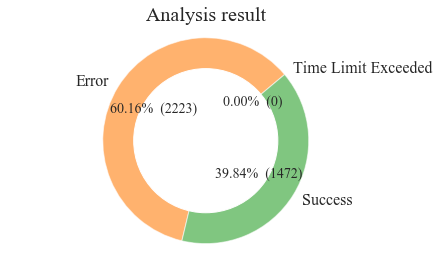

In [7]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def get_success_rates(df):
    print "Total number of entries: "+ str(len(df))
    print "Total number after bad DOIs are removed: "+ str(len(df))
    
    print "Unique DOIs: "+ str(len(df['doi'].unique()))
    
    # calculate success
    success = (df['result'] == 'success').sum()
    print "Success: " + str(success)+ " out of " + str(len(df)) +" => "+ str(success*1.0/len(df))
    
    til = (df['result'] == 'time limit exceeded').sum()
    print "TIL: " + str(til)+ " out of " + str(len(df)) +" => "+ str(til*1.0/len(df))
    
    error = len(df)-til-success
    print "Error: " + str(error)+ " out of " + str(len(df)) +" => "+ str(error*1.0/len(df))
    
    return [til, error, success]

def plot_code(df, plot_title, plot_name, aggregation=False):
    labels = ["Time Limit Exceeded",'Error', 'Success']
    if aggregation:
        sizes = get_aggregated(df)
    else:
        sizes = get_success_rates(df)
     
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    #fig1.savefig("plots/{}".format(plot_name), dpi=100)
    
dfe = df[df.result.notnull()]
plot_code(dfe, "Analysis result", "fin_result2.png")

## Merge the datasets

In [8]:
total = pd.merge(df,metadata,on='doi')

In [9]:
len(total)

6832

## Merge aggrigated

In [10]:
agg = total.groupby(['doi']).success.max().reset_index()

In [11]:
agg.head()

,doi,success
0,doi:10.7910/DVN/03CDTK,NaN
1,doi:10.7910/DVN/05BSPP,0.0
2,doi:10.7910/DVN/0BFF0K,1.0
3,doi:10.7910/DVN/0BPVCH,NaN
4,doi:10.7910/DVN/0DE35E,1.0


In [12]:
len(agg)

1923

In [13]:
agg_total = pd.merge(agg, metadata, on='doi')

In [14]:
len(agg_total)

1923

## Analysis

- Drop if NaN or TLE

In [15]:
df = total
df_temp = df.drop(df[df.result.isnull() | (df['result'] == 'time limit exceeded')].index)

In [16]:
df_temp.result.isna().sum()

0

In [17]:
total = df_temp

In [18]:
def success(el):
    if pd.isna(el):
        return el
    if el == 'success':
        return 1
    if len(str(el))>1:
        return 0
    else:
        el

total['success']=total["result"].apply(success)

## Journal 

In [19]:
journals = total[total['type']=="JOURNALS"]
print("All journals' success rate: "+ str(journals.success.sum()*1./len(journals)))

All journals' success rate: 0.42024253731343286


In [20]:
def fix_name(el):
    return el.split('Dataverse')[0].strip()

def fix_name2(x):
    if 'International Interactions (II)' in x:
        return 'International Interactions (II)'
    if 'American Journal of Political Science (AJPS)' in x:
        return 'American Journal of Political\nScience (AJPS)'
    if 'British Journal of Political Science' in x:
        return 'British Journal of\nPolitical Science'
    if 'American Political Science Review' in x:
        return 'American Political\nScience Review'
    if 'Review of Economics and Statistics' in x:
        return 'Review of Economics\nand Statistics'
    if 'Political Science Research and Methods (PSRM)' in x:
        return 'Political Science Research\nand Methods (PSRM)'
    if 'Journal of Experimental Political Science' in x:
        return 'Journal of Experimental\nPolitical Science'
    if 'International Studies Quarterly' in x:
        return 'International\nStudies Quarterly'
    return x

In [21]:
journals.name = journals.name.apply(fix_name)
journals.name = journals.name.apply(fix_name2)

/Users/anatrisovic/Desktop/aws-dataverse/env/lib/python2.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [22]:
# journal policy
policy = pd.read_csv("data/journal-policy.txt", sep ='\t')
policy.name = policy.name.apply(fix_name2)
policy

,name,link,type,level
0,American Journal of Political\nScience (AJPS),https://ajps.org/ajps-verification-policy/,verification,5
1,British Journal of\nPolitical Science,https://www.cambridge.org/core/services/aop-fi...,required,3
2,American Political\nScience Review,https://www.apsanet.org/APSR-Submission-Guidel...,required,3
3,Review of Economics\nand Statistics,https://www.mitpressjournals.org/journals/rest...,required,3
4,Political Science Research\nand Methods (PSRM),https://www.cambridge.org/core/journals/politi...,verification,5
5,Journal of Experimental\nPolitical Science,https://www.cambridge.org/core/journals/journa...,required,3
6,International\nStudies Quarterly,https://academic.oup.com/isq/pages/General_Ins...,required,3
7,International Interactions (II),https://www.tandfonline.com/action/authorSubmi...,encouraged,2
8,The Journal of Politics,https://www.journals.uchicago.edu/journals/jop...,no policy,1
9,Political Analysis,https://www.cambridge.org/core/journals/politi...,reviewed,4


In [23]:
journal_policy = pd.merge(journals,policy,on='name')

In [24]:
len(journal_policy)

1971

In [25]:
#temp = temp[temp.type_y != "no policy"]

In [26]:
temp = journal_policy
temp = temp.groupby(['name','publicationDate']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum'] / temp['success']['count']
temp.head()

name publicationDate success  \
                                                                     sum   
0  American Journal of Political\nScience (AJPS)            2015      25   
1  American Journal of Political\nScience (AJPS)            2016      13   
2  American Journal of Political\nScience (AJPS)            2017      53   
3  American Journal of Political\nScience (AJPS)            2018      24   
4  American Journal of Political\nScience (AJPS)            2019      61   

                s  
  count            
0    30  0.833333  
1    20  0.650000  
2    67  0.791045  
3    54  0.444444  
4   103  0.592233

In [27]:
#df = temp.pivot(columns='name', index='publicationDate', values='s').reset_index()
#df.fillna(0.0, inplace=True)

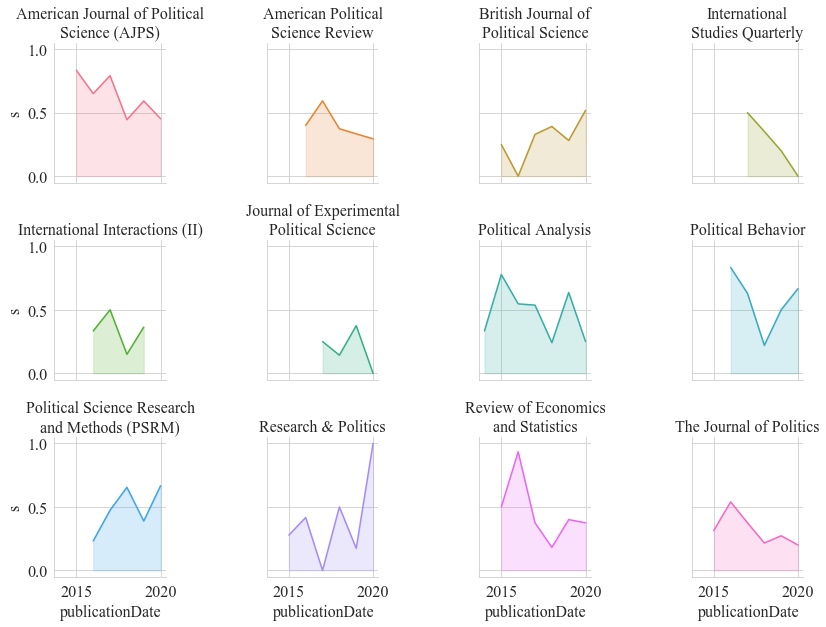

In [28]:
df= temp
g = sns.FacetGrid(df, col='name', hue='name', col_wrap=4, )
 
# Add the line over the area with the plot function
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
#plt.subplots_adjust(top=0.92)
#g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

#fig.tight_layout()
#fig.show()

# Aggregated

In [29]:
ag_journals = agg_total[agg_total['type']=="JOURNALS"]
ag_journals = ag_journals.drop(ag_journals[ag_journals.success.isnull()].index)

ag_journals.name = ag_journals.name.apply(fix_name)
ag_journals.name = ag_journals.name.apply(fix_name2)

In [30]:
print("Aggregated all journals' success rate: "+ str(ag_journals.success.sum()/len(ag_journals)))

Aggregated all journals' success rate: 0.4729381443298969


In [31]:
ag_journal_policy = pd.merge(ag_journals,policy,on='name')

In [32]:
# temp = temp[temp.type_y != "no policy"]

In [33]:
temp = ag_journal_policy
temp = temp.groupby(['name','publicationDate','type_y']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum'] / temp['success']['count']

In [34]:
pal = sns.color_palette("nipy_spectral")

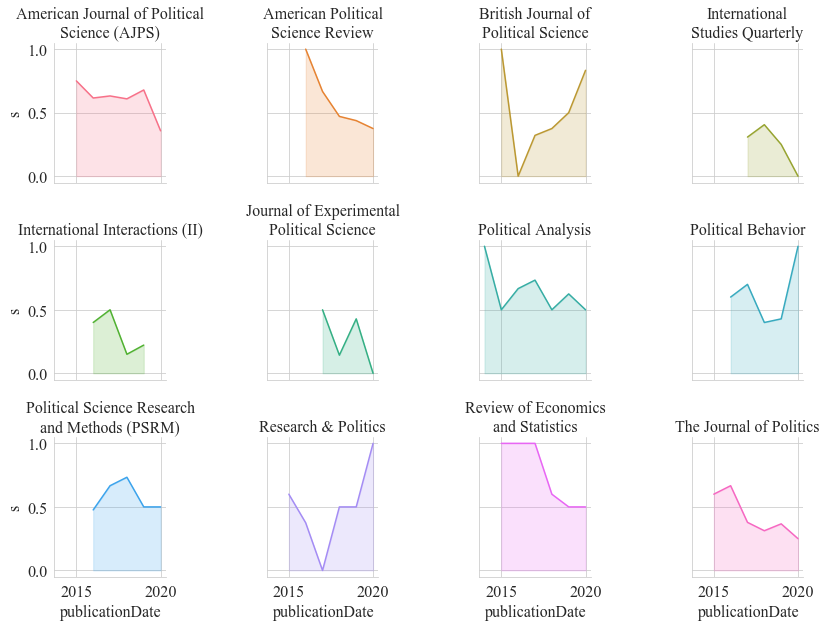

In [35]:
df= temp
g = sns.FacetGrid(df, col='name', hue='name', col_wrap=4, )
 
# Add the line over the area with the plot function
colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
#plt.subplots_adjust(top=0.92)
#g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

#fig.tight_layout()
#g.savefig("over_time.png")
#fig.show()

# Aggregated results plotted per policy type

In [36]:
temp = ag_journal_policy
temp = temp.groupby(['publicationDate','type_y']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum']*100. / temp['success']['count']

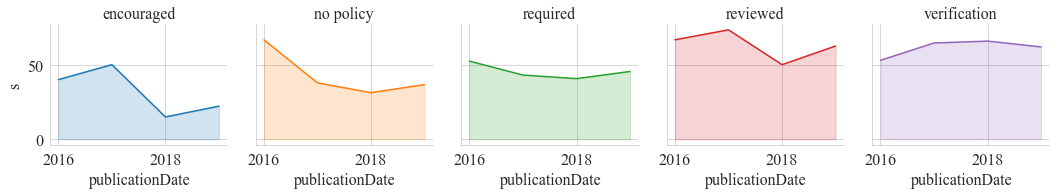

In [37]:
df= temp
#g = sns.FacetGrid(df, col='type_y', hue='type_y', col_wrap=5, )
g = sns.FacetGrid(
    df[(df['publicationDate']<2020) & (df['publicationDate']>2015)], col='type_y', hue='type_y', col_wrap=5, )


# Add the line over the area with the plot function
colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plo
#plt.subplots_adjust(top=0.92)
#g = g.fig.suptitle('Evolution of the value of stuff in 16 countries')

#fig.tight_layout()
#g.savefig("policy_type.png")
#plt.title("Success rate per policy type from 2016 to 2019")
#fig.show()

In [38]:
# temp.pivot(columns='success', index='name', values='publicationDate')

# Journals

In [39]:
barWidth = 0.8

def get_stats(df):
    res = df.groupby(
        ['success', 'name']).size().reset_index().pivot(columns='success', index='name', values=0)

    res.fillna(0.0, inplace=True)
    res['total'] = [i+j for i,j in zip(res[1],res[0])]

    res['s'] = [i / j * 100 for i,j in zip(res[1], res['total'])]

    res = res.sort_values(by=['total'], ascending=False)
    return res

import matplotlib.patches as patches
def make_plot(plt, temp):
    colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
    
    names = list(temp.name)
    r= range(0,len(temp['s']))
    plt.bar(r, temp['s'], color=temp.type.map(colors), alpha=1., edgecolor='black', width=barWidth)

    plt.set_xticks(r)
    plt.set_xticklabels(names, rotation=90, fontsize=14)

    labels = list(colors.keys())
    handles = [patches.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

    legend = plt.legend(
        handles, labels, frameon=True, facecolor='white', edgecolor='white', 
        title="Data sharing policy type", loc='best', ncol=3, prop={'size': 13})
 
    temp['names'] = temp.index
    temp = temp.reset_index(drop=True)

    temp.s = temp.s.round(1)
    temp.total = temp.total.astype(int)

    for i, rows in temp.iterrows():
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.2, 3), rotation=0, color="black", size=12, 
            bbox=dict(facecolor='white', boxstyle='round', alpha=0.80, pad=0.01))

    plt.set_ylim(0,90)

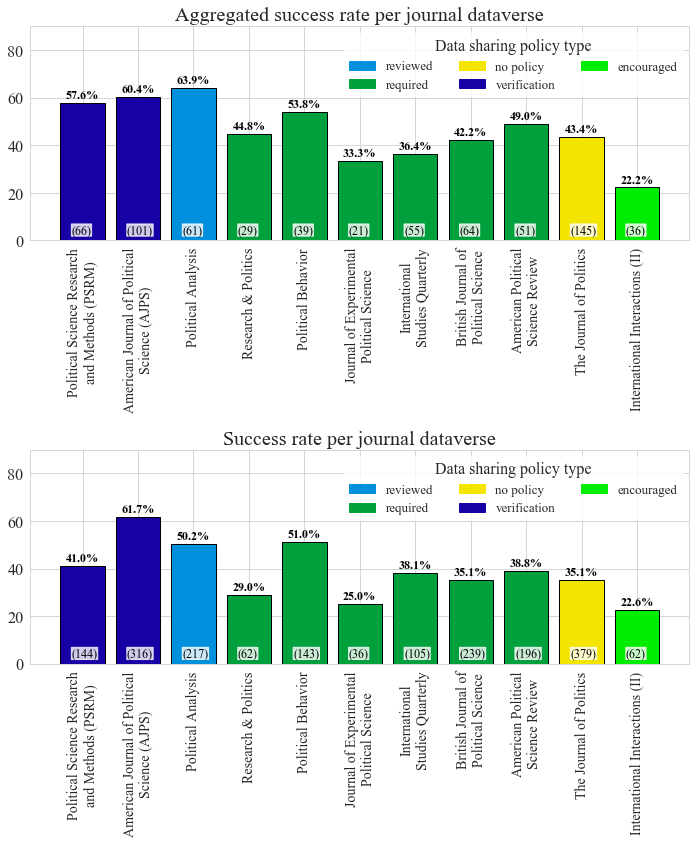

In [61]:
fig, axs = plt.subplots(2,1, figsize=(10,12))

j2 = get_stats(ag_journals).head(11)
j2 = pd.merge(j2.reset_index(),policy,on='name').sort_values(by=['type','name'], ascending=False)
make_plot(axs[0], j2)
axs[0].set_title("Aggregated success rate per journal dataverse", size=20)

j1 = get_stats(journals)
j1 = pd.merge(j1.reset_index(),policy,on='name').sort_values(by=['type','name'], ascending=False)
j1 = j1.drop(j1[~j1.name.isin(j2.name)].index)
make_plot(axs[1], j1)
axs[1].set_title("Success rate per journal dataverse", size=20)

fig.tight_layout()
plt.savefig("plots/publisher_temp.png")
fig.show()

# Journal per year

In [41]:
journals.publisher.unique()

array(['ajps', 'BJPolS', 'jop', 'restat', 'pan', 'ipsr-risp',
       'the_review', 'LAPS', 'PSRM', 'isq', 'IOJ', 'lsq', 'xps',
       'researchandpolitics', 'world-politics', 'JPublicPolicy',
       'perspectives', 'internationalinteractions', 'culturalanalytics',
       'economics', 'polbehavior', 'FPA', 'JAERE', 'bpsr', 'ps', 'qje',
       'jhr', 'tpmnewsletter', 'palcomms', 'jlc', 'isec', 'JJPS', 'cjip'],
      dtype=object)

In [42]:
top = [
    'jop', 'ajps', 'PSRM', 'BJPolS', 'pan', 'isq','IOJ','culturalanalytics','JPublicPolicy',
    'the_review','polbehavior','restat','internationalinteractions','xps','researchandpolitics']

In [43]:
journals_subset = journals.drop(journals[~journals.publisher.isin(top)].index)

In [44]:
temp = journals_subset
temp = temp.groupby(['name','publicationDate']).agg({'success': ['sum','count']}).reset_index()
temp['s']=temp['success']['sum']*100. / temp['success']['count']

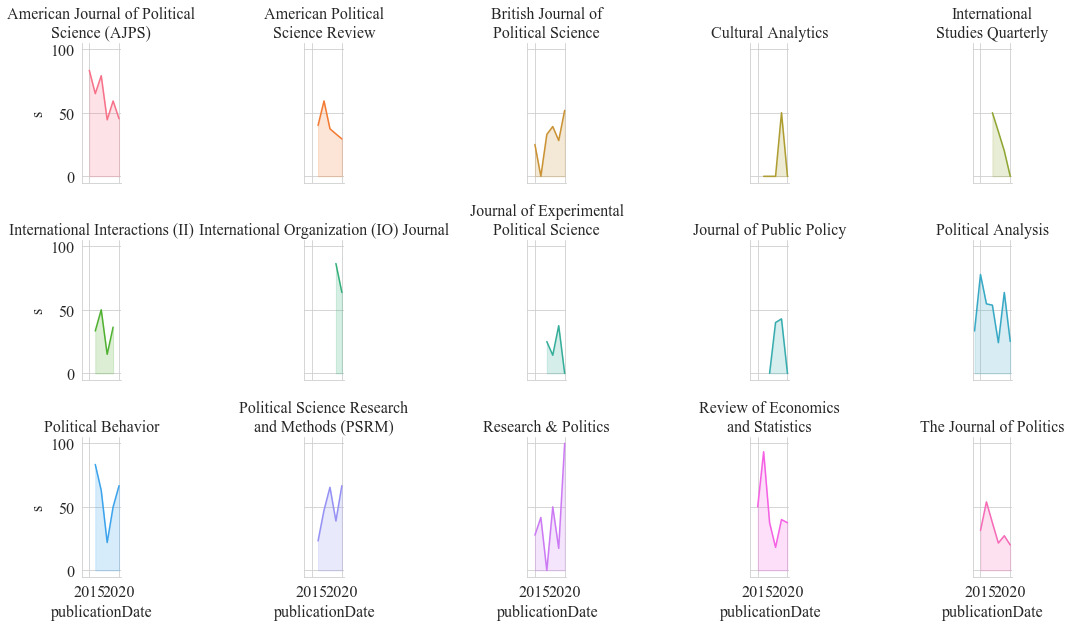

In [45]:
df= temp
g = sns.FacetGrid(df, col='name', hue='name', col_wrap=5, )
 
# Add the line over the area with the plot function
colors = {"no policy": pal[4], "encouraged": pal[3], "required": pal[2], "reviewed": pal[1], "verification": pal[0]} 
g = g.map(plt.plot, 'publicationDate', 's')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'publicationDate', 's', alpha=0.2).set_titles("{col_name}")
 
# Control the title of each facet
g = g.set_titles("{col_name}")

# Re-execution rate per publication year

In [46]:
def plot_func(temp, ptitle, pname):
    temp.fillna(0.0, inplace=True)
    temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]

    temp['s'] = [i* 100./ j  for i,j in zip(temp[1], temp['total'])]
    temp['f'] = [i* 100./ j  for i,j in zip(temp[0], temp['total'])]
    #temp['t'] = [i / j * 100 for i,j in zip(temp[2], temp['total'])]

    names = list(temp.index)
    r= range(0,len(temp['s']))

    plt.figure(figsize=(6,5))

    barWidth = 0.8
    
    sns.barplot(x=r, y="s", data=temp,  color=sns.color_palette("Set2")[0], label="Success")
    sns.barplot(x=r, y="f", data=temp, bottom=temp['s'], color=sns.color_palette("Set2")[1], label="Error")
    
    #plt.bar(r, temp['s'], color='#b5ffb9', edgecolor='black', width=barWidth, label="Success")
    #plt.bar(r, temp['f'], color='#cce6ff', bottom=temp['s'], edgecolor='black', width=barWidth, label="Error")

    plt.xticks(r, names, rotation=90, fontsize=15)
    plt.xlabel("Year", size=15)
    plt.ylabel("Success rate (%)", size=15)

    plt.legend(loc='best', ncol=1,prop={'size': 12})

    temp['year'] = temp.index
    #temp['names'] =temp['names'].apply(fix_name)
    temp = temp.reset_index(drop=True)

    #temp.s = temp.s+temp.t
    temp.s = temp.s.round(1)
    temp.total = temp.total.astype(int)

    for i, rows in temp.iterrows():
        if rows["s"]<=0:
            plt.annotate(
                str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
            plt.annotate(
                "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)
        elif rows["s"]>95:
            plt.annotate(
                str(rows["s"])+"%", xy=(i-0.3, rows["s"]-5), rotation=0, color="black", size=12, weight='bold')
            plt.annotate(
                "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)
        else:
            plt.annotate(
                str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
            plt.annotate(
                "("+str(int(rows["total"]))+")", xy=(i-0.3, 3), rotation=0, color="black", size=12)


    plt.title(ptitle, size=20)

    #plt.savefig("plots/{}.png".format(pname), bbox_inches = "tight")
    plt.show()

In [47]:
total = total[total['publicationDate'] > 2014]

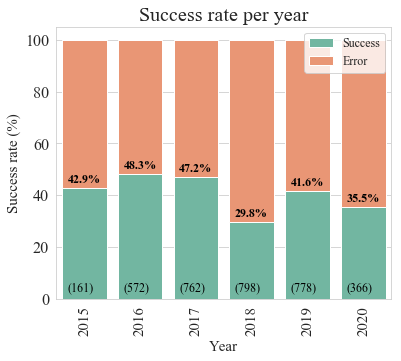

In [48]:
temp = total.groupby(
    ['success', 'publicationDate']).size().reset_index().pivot(
    columns='success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year", pname="per_year")

In [49]:
total['r32_success']=total["r32"].apply(success)
total['r36_success']=total["r36"].apply(success)
total['r40_success']=total["r40"].apply(success)

/Users/anatrisovic/Desktop/aws-dataverse/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/anatrisovic/Desktop/aws-dataverse/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anatrisovic/Desktop/aws-dataverse/env/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

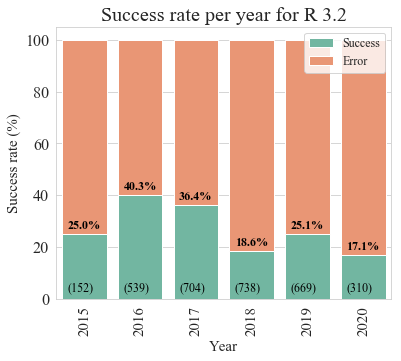

In [50]:
temp = total.groupby(
    ['r32_success', 'publicationDate']).size().reset_index().pivot(
    columns='r32_success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year for R 3.2", pname="per_year_r32")

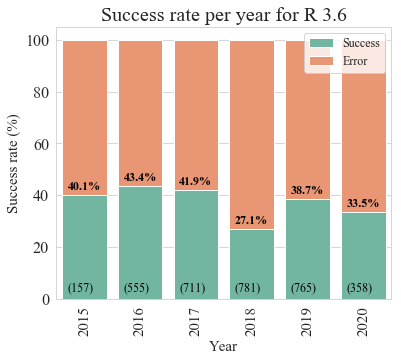

In [51]:
temp = total.groupby(
    ['r36_success', 'publicationDate']).size().reset_index().pivot(
    columns='r36_success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year for R 3.6", pname="per_year_r36")

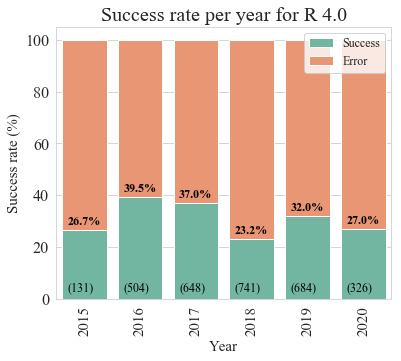

In [52]:
temp = total.groupby(
    ['r40_success', 'publicationDate']).size().reset_index().pivot(
    columns='r40_success', index='publicationDate', values=0)
plot_func(temp, ptitle="Success rate per year for R 4.0", pname="per_year_r40")

In [53]:
temp

r40_success,0.0,1.0,total,s,f,year
publicationDate,,,,,,
2015,96,35,131,26.717557,73.282443,2015
2016,305,199,504,39.484127,60.515873,2016
2017,408,240,648,37.037037,62.962963,2017
2018,569,172,741,23.211876,76.788124,2018
2019,465,219,684,32.017544,67.982456,2019
2020,238,88,326,26.993865,73.006135,2020


# Re-execution rate per subject

In [54]:
total['subject'] = total.subject.str.replace(';Social Sciences', '')
total.groupby(['subject']).size().nlargest(10)

/Users/anatrisovic/Desktop/aws-dataverse/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


subject
Social Sciences                                                                              2942
Earth and Environmental Sciences                                                               63
Medicine; Health and Life Sciences                                                             63
Business and Management                                                                        59
Law                                                                                            49
Earth and Environmental Sciences;Mathematical Sciences;Medicine; Health and Life Sciences      44
Arts and Humanities                                                                            36
Computer and Information Science                                                               30
Other                                                                                          28
Agricultural Sciences                                                                          19
dtype: int64

In [55]:
total.subject = total.subject.apply(lambda x: 'Physics' if 'Physics' in x else x)
total.subject = total.subject.apply(lambda x: 'Health and\nLife Sciences' if 'Health and Life Sciences' in x else x)
total.subject = total.subject.apply(lambda x: 'Earth and\nEnvironmental Sciences' if 'Earth and Environmental Sciences' in x else x)
total.subject = total.subject.apply(lambda x: 'Law' if 'Law' in x else x)
total.subject = total.subject.apply(lambda x: 'Computer and\nInformation Science' if 'Computer and Information Science' in x else x)
total.subject = total.subject.apply(lambda x: 'Agricultural Sciences' if 'Agricultural Sciences' in x else x)
total.subject = total.subject.apply(lambda x: 'Business and\nManagement' if 'Business and Management' in x else x)

In [56]:
total.groupby(['subject']).size()

subject
Agricultural Sciences                  21
Arts and Humanities                    36
Business and\nManagement               60
Computer and\nInformation Science      45
Earth and\nEnvironmental Sciences      77
Health and\nLife Sciences             133
Law                                    62
Mathematical Sciences                  14
Other                                  28
Physics                                19
Social Sciences                      2942
dtype: int64

In [57]:
temp = total.groupby(
    ['success', 'subject']).size().reset_index().pivot(columns='success', index='subject', values=0)
temp

success,0,1
subject,,
Agricultural Sciences,18,3
Arts and Humanities,31,5
Business and\nManagement,35,25
Computer and\nInformation Science,25,20
Earth and\nEnvironmental Sciences,48,29
Health and\nLife Sciences,54,79
Law,29,33
Mathematical Sciences,10,4
Other,13,15


In [58]:
#temp.fillna(0.0, inplace=True)
temp['total'] = [i+j for i,j in zip(temp[1],temp[0])]
#temp['total'] = [i+j for i,j in zip(temp[2],temp['total'])]

temp['s'] = [(i*1./j) * 100 for i,j in zip(temp[1], temp['total'])]
temp['f'] = [(i*1./j) * 100 for i,j in zip(temp[0], temp['total'])]

#temp['sortby'] = [i+j for i,j in zip(temp['s'], temp['t'])]

temp = temp.sort_values(by=['s'], ascending=False).head(11)
temp

success,0,1,total,s,f
subject,,,,,
Health and\nLife Sciences,54,79,133,59.398496,40.601504
Other,13,15,28,53.571429,46.428571
Law,29,33,62,53.225806,46.774194
Computer and\nInformation Science,25,20,45,44.444444,55.555556
Business and\nManagement,35,25,60,41.666667,58.333333
Social Sciences,1759,1183,2942,40.210741,59.789259
Earth and\nEnvironmental Sciences,48,29,77,37.662338,62.337662
Mathematical Sciences,10,4,14,28.571429,71.428571
Agricultural Sciences,18,3,21,14.285714,85.714286


In [59]:
names = list(temp.index)
r= range(0,len(temp['s']))

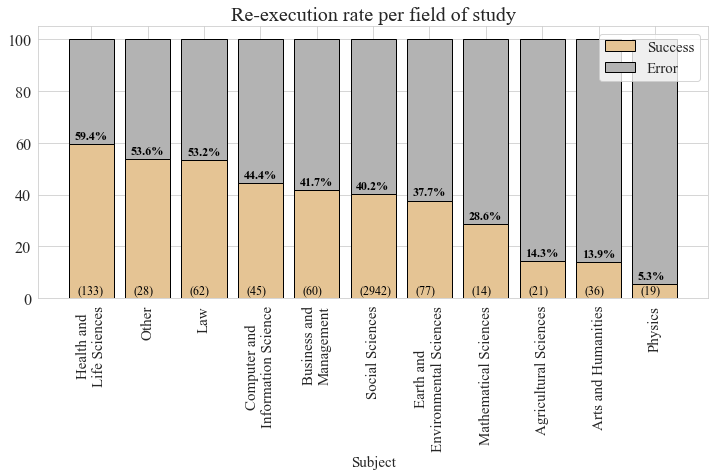

In [60]:
plt.figure(figsize=(12,5))

plt.bar(r, temp['s'], color=sns.color_palette("Set2")[6], edgecolor='black', width=barWidth, label="Success")
#plt.bar(r, temp['t'], bottom=temp['s'], color='#fFF842', edgecolor='black', width=barWidth, label="TLE")
plt.bar(r, temp['f'], bottom=temp['s'], color=sns.color_palette("Set2")[7], edgecolor='black', width=barWidth, label="Error")

plt.xticks(r, names, rotation=90, fontsize=15)
plt.xlabel("Subject", size=15)

plt.legend(loc='best', ncol=1,prop={'size': 15})

temp['year'] = temp.index
temp = temp.reset_index(drop=True)

#temp.s = temp.s+temp.t
temp.s = temp.s.round(1)
temp.total = temp.total.astype(int)

for i, rows in temp.iterrows():
    if rows["s"]<=0:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+10), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.25, 2), rotation=0, color="black", size=12)
    else:
        plt.annotate(
            str(rows["s"])+"%", xy=(i-0.3, rows["s"]+2), rotation=0, color="black", size=12, weight='bold')
        plt.annotate(
            "("+str(int(rows["total"]))+")", xy=(i-0.25, 2), rotation=0, color="black", size=12)


plt.title("Re-execution rate per field of study", size=20)

#plt.savefig("plots/subject_new2.png", bbox_inches = "tight")
plt.show()